# 使用 Logistic Regression 对多标签评论进行分类


In [1]:
pip install -U -i https://pypi.tuna.tsinghua.edu.cn/simple scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

## 加载训练和测试数据

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.sample(5) #随机抽取五个样本数据，在训练数据中，注释被标记为六个类别中的一个或多个;有毒、严重有毒、淫秽、威胁、侮辱和身份仇恨。这本质上是一个多标签分类问题。

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
16581,2bba48b53f376eca,"""\n\n nsri and ssri addiction \nA heading shou...",0,0,0,0,0,0
30437,50c4e6e5d9c981f0,"""Thanks for experimenting with Wikipedia. Your...",0,0,0,0,0,0
37426,63ed53bd46651d6a,In case you forgotten I was already blocked pe...,1,0,1,0,1,0
136649,db076c23f98b2da8,He apparently thinks that anyone who disagrees...,0,0,0,0,0,0
38038,6586d1cc46e36eae,"""\n\nLassner and Troen, 2007\nThis book is use...",0,0,0,0,0,0


In [5]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

In [6]:
#检查数据中的缺失值
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
#计算未标记评论百分比 结果显示约89.83%的评论 不包括负面特征，数据在这些类别较为稀疏，这也意味着负面评论在整体数据中属于少数评论
unlabelled_in_all = train_df[(train_df['toxic']!=1) & (train_df['severe_toxic']!=1) & (train_df['obscene']!=1) & 
                            (train_df['threat']!=1) & (train_df['insult']!=1) & (train_df['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_df)*100)

Percentage of unlabelled comments is  89.83211235124176


In [8]:
#检查评论内容为空的值
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [9]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [10]:
no_comment = test_df[test_df['comment_text'].isnull()]
no_comment
# 训练和测试数据中的所有行都包含注释，因此无需清理 null 字段

,id,comment_text


In [11]:
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


In [12]:
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))
#train_df 数据集添加一个新特征 char_length，用于后续的数据分析,帮助模型更好的进行分类预测

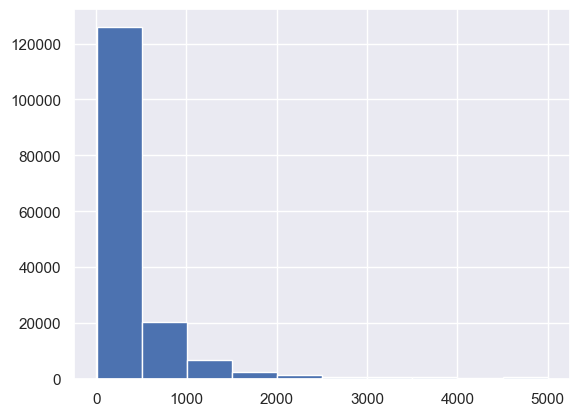

In [13]:
#绘制 train_df 数据集中 char_length 列数据的直方图
sns.set()
train_df['char_length'].hist()
plt.show()
#大多数文本长度在500字符以内，有些长达5000个字符

In [14]:
data  = train_df[cols_target]

<Axes: title={'center': 'Correlation of features & targets'}>

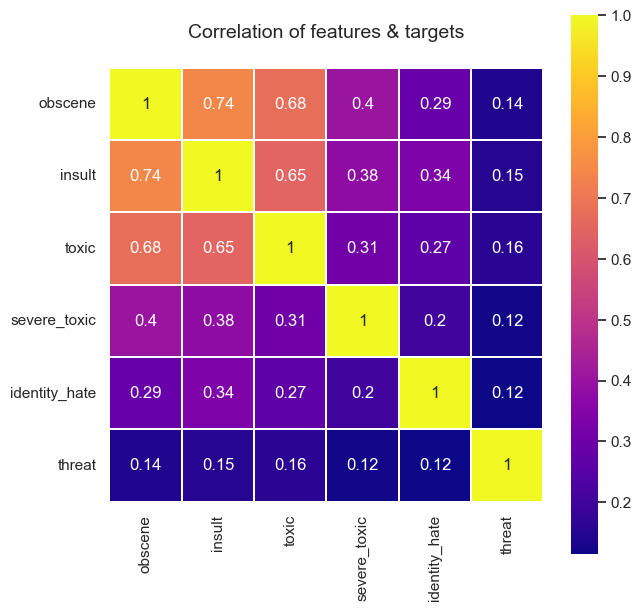

In [15]:
#检查一下目标变量之间的相关性。
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

In [16]:
test_df['char_length'] = test_df['comment_text'].apply(lambda x: len(str(x)))

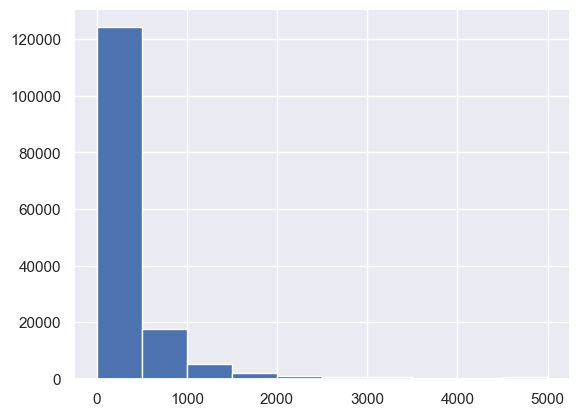

In [17]:
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

## 清除评论文本

In [18]:
# 函数对文本进行清洗和预处理，可以使文本数据更加规范、统一，减少噪声和干扰
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [19]:
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
#对训练集和测试集中的文本评论数据进行清洗，去除噪声和不规范表达
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))

In [20]:
# clean the comment_text in test_df [Thanks, Pulkit Jha.]
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))

### 从整个训练和测试数据中定义 X，用于 Vectorizer 的标记化

In [21]:
train_df = train_df.drop('char_length',axis=1)
X = train_df.comment_text
test_X = test_df.comment_text
print(X.shape, test_X.shape)

(159571,) (153164,)


## 向量化数据

In [22]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [23]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [24]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618972 stored elements in Compressed Sparse Row format>

## 解决多标签分类问题 
## Binary Relevance - 使用 Logistic Regression 构建多标签分类器

In [25]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary = pd.read_csv('sample_submission.csv')

for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

... Processing obscene


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.983255102744233
... Processing insult


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9755344016143285
... Processing toxic


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9639470831166064
... Processing severe_toxic


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9920662275726793
... Processing identity_hate


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training accuracy is 0.9939901360522903
... Processing threat
Training accuracy is 0.9981199591404453


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
submission_binary.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999957,0.460268,0.999965,0.050124,0.972258,0.433720
1,0000247867823ef7,0.002463,0.000443,0.000402,0.000324,0.003252,0.000410
2,00013b17ad220c46,0.010775,0.000117,0.003212,0.000035,0.007652,0.001238
3,00017563c3f7919a,0.001342,0.002159,0.000978,0.000117,0.000835,0.000034
4,00017695ad8997eb,0.019449,0.000812,0.001247,0.000602,0.003270,0.000568


In [27]:
# generate submission file
submission_binary.to_csv('submission_binary.csv',index=False)

## 分类器链 - 使用 Logistic 回归构建多标签分类器

In [28]:
# create submission file
submission_chains = pd.read_csv('sample_submission.csv')

# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [29]:
for label in cols_target:
    print('... Processing {}'.format(label))
    y = train_df[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm,y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training Accuracy is {}'.format(accuracy_score(y,y_pred_X)))
    # make predictions from test_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_chains[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

... Processing obscene


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.983255102744233
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
... Processing insult


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.9818137380852411
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
... Processing toxic


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.967575561975547
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
... Processing severe_toxic


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.9930501156225129
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
... Processing identity_hate


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy is 0.9956132379943724
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
... Processing threat
Training Accuracy is 0.9985649021438733
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


C:\Users\LiSnP\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
submission_chains.head()


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999972,3.978294e-01,0.999965,0.193270,0.893702,0.599350
1,0000247867823ef7,0.002662,1.341451e-09,0.000402,0.000072,0.003678,0.000136
2,00013b17ad220c46,0.007965,3.799504e-10,0.003212,0.000009,0.004084,0.000533
3,00017563c3f7919a,0.001164,2.053929e-08,0.000978,0.000063,0.000569,0.000004
4,00017695ad8997eb,0.022158,1.945896e-09,0.001247,0.000158,0.001547,0.000103


In [31]:
# generate submission file
submission_chains.to_csv('submission_chains.csv', index=False)

In [32]:
# create submission file
submission_combined = pd.read_csv('sample_submission.csv')

In [33]:
# corr_targets = ['obscene','insult','toxic']
for label in cols_target:
    submission_combined[label] = 0.5*(submission_chains[label]+submission_binary[label])

In [34]:
submission_combined.head()


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999965,0.429049,0.999965,0.121697,0.932980,0.516535
1,0000247867823ef7,0.002563,0.000222,0.000402,0.000198,0.003465,0.000273
2,00013b17ad220c46,0.009370,0.000059,0.003212,0.000022,0.005868,0.000885
3,00017563c3f7919a,0.001253,0.001079,0.000978,0.000090,0.000702,0.000019
4,00017695ad8997eb,0.020804,0.000406,0.001247,0.000380,0.002409,0.000336


In [35]:
# generate submission file
submission_combined.to_csv('submission_combined.csv', index=False)